# MathE Dataset - Student Performance Prediction

This notebook analyzes the MathE dataset to build a machine learning model that predicts whether a student will answer a mathematics question correctly based on:
- Student country
- Question characteristics (ID, level, topic, subtopic)
- Question difficulty level (Basic/Advanced)

**Goal:** Create a simple classification model for the Flask web application.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

## 2. Load and Explore the Dataset

In [3]:
# Load the dataset with proper encoding
df = pd.read_csv('../MathE dataset.csv', delimiter=';', encoding='latin-1')

print("Dataset shape:", df.shape)
print("\nDataset info:")
df.info()

Dataset shape: (9546, 8)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9546 entries, 0 to 9545
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Student ID       9546 non-null   int64 
 1   Student Country  9546 non-null   object
 2   Question ID      9546 non-null   int64 
 3   Type of Answer   9546 non-null   int64 
 4   Question Level   9546 non-null   object
 5   Topic            9546 non-null   object
 6   Subtopic         9546 non-null   object
 7   Keywords         9546 non-null   object
dtypes: int64(3), object(5)
memory usage: 596.8+ KB


In [4]:
# Display first few rows
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords
0,647,Ireland,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
1,41,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
2,340,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
3,641,Italy,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
4,669,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."


In [5]:
# Check column names and basic statistics
print("Column names:")
print(df.columns.tolist())
print("\nDataset description:")
df.describe(include='all')

Column names:
['Student ID', 'Student Country', 'Question ID', 'Type of Answer', 'Question Level', 'Topic', 'Subtopic', 'Keywords']

Dataset description:


,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords
count,9546.000000,9546,9546.000000,9546.000000,9546,9546,9546,9546
unique,NaN,8,NaN,NaN,2,14,24,365
top,NaN,Portugal,NaN,NaN,Basic,Linear Algebra,Vector Spaces,"Linear application,Linearity"
freq,NaN,5495,NaN,NaN,7844,5726,2749,443
mean,775.402263,NaN,478.912319,0.468259,NaN,NaN,NaN,NaN
std,460.590559,NaN,249.244061,0.499018,NaN,NaN,NaN,NaN
min,26.000000,NaN,77.000000,0.000000,NaN,NaN,NaN,NaN
25%,380.000000,NaN,323.000000,0.000000,NaN,NaN,NaN,NaN
50%,885.000000,NaN,428.000000,0.000000,NaN,NaN,NaN,NaN
75%,1219.000000,NaN,571.000000,1.000000,NaN,NaN,NaN,NaN


## 3. Exploratory Data Analysis (EDA)

In [6]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

Missing values per column:
Student ID         0
Student Country    0
Question ID        0
Type of Answer     0
Question Level     0
Topic              0
Subtopic           0
Keywords           0
dtype: int64

Data types:
Student ID          int64
Student Country    object
Question ID         int64
Type of Answer      int64
Question Level     object
Topic              object
Subtopic           object
Keywords           object
dtype: object


Target variable distribution (Type of Answer):
Type of Answer
0    5076
1    4470
Name: count, dtype: int64

Correct answers: 46.83%
Incorrect answers: 53.17%


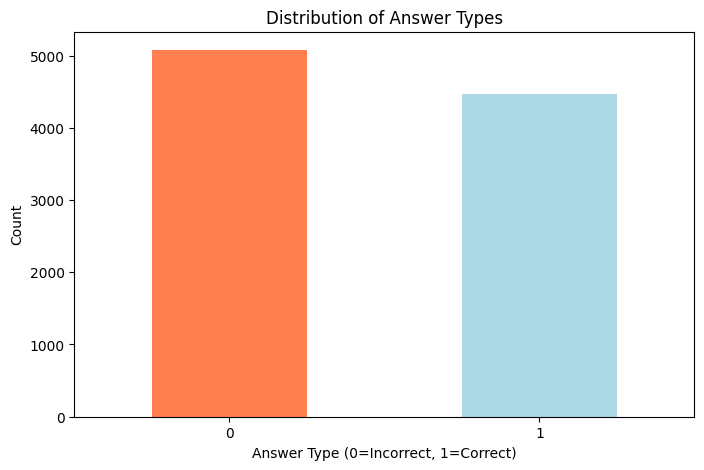

In [7]:
# Analyze target variable distribution
print("Target variable distribution (Type of Answer):")
print(df['Type of Answer'].value_counts())
print(f"\nCorrect answers: {df['Type of Answer'].value_counts()[1] / len(df):.2%}")
print(f"Incorrect answers: {df['Type of Answer'].value_counts()[0] / len(df):.2%}")

# Plot target distribution
plt.figure(figsize=(8, 5))
df['Type of Answer'].value_counts().plot(kind='bar', color=['coral', 'lightblue'])
plt.title('Distribution of Answer Types')
plt.xlabel('Answer Type (0=Incorrect, 1=Correct)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Performance by Country:
                    Success_Rate  Total_Answers
Student Country                                
Slovenia                   0.687            755
Romania                    0.583             60
Ireland                    0.460            300
Portugal                   0.454           5495
Italy                      0.446           1358
Lithuania                  0.436           1443
Spain                      0.429             28
Russian Federation         0.346            107


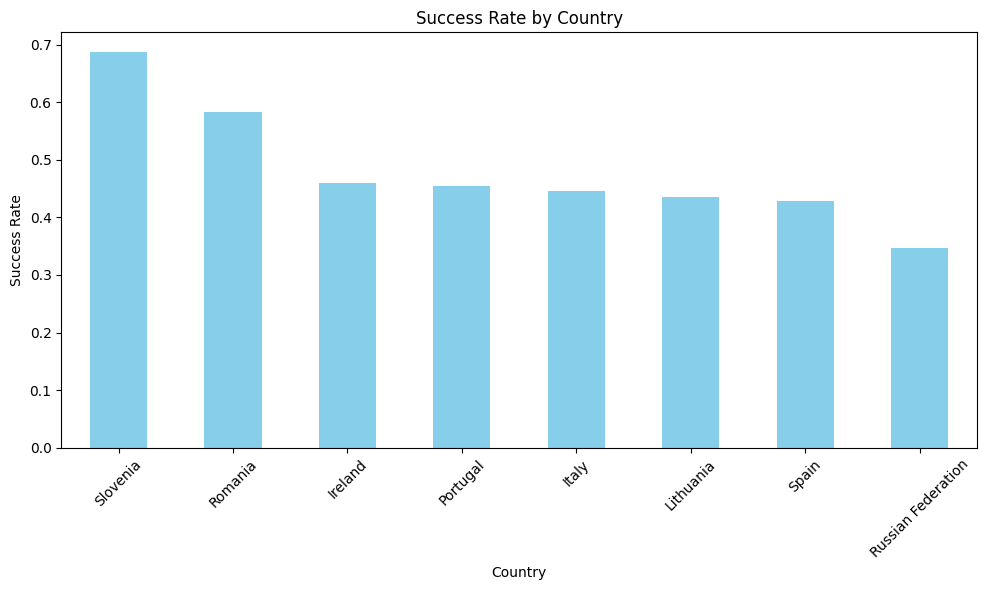

In [8]:
# Performance by country
country_performance = df.groupby('Student Country')['Type of Answer'].agg(['mean', 'count']).round(3)
country_performance.columns = ['Success_Rate', 'Total_Answers']
country_performance = country_performance.sort_values('Success_Rate', ascending=False)

print("Performance by Country:")
print(country_performance)

# Visualize country performance
plt.figure(figsize=(10, 6))
country_performance['Success_Rate'].plot(kind='bar', color='skyblue')
plt.title('Success Rate by Country')
plt.xlabel('Country')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Performance by Topic
topic_performance = df.groupby('Topic')['Type of Answer'].agg(['mean', 'count']).round(3)
topic_performance.columns = ['Success_Rate', 'Total_Answers']
topic_performance = topic_performance.sort_values('Success_Rate', ascending=False)

print("Performance by Topic:")
print(topic_performance)

# Performance by Question Level
level_performance = df.groupby('Question Level')['Type of Answer'].agg(['mean', 'count']).round(3)
level_performance.columns = ['Success_Rate', 'Total_Answers']

print("\nPerformance by Question Level:")
print(level_performance)

Performance by Topic:
                                     Success_Rate  Total_Answers
Topic                                                           
Set Theory                                  0.643             42
Graph Theory                                0.582             55
Differential Equations                      0.537            108
Linear Algebra                              0.490           5726
Analytic Geometry                           0.489            358
Statistics                                  0.479            340
Fundamental Mathematics                     0.466            818
Complex Numbers                             0.454            592
Integration                                 0.444            144
Numerical Methods                           0.387            310
Optimization                                0.385            182
Probability                                 0.375            128
Real Functions of a single variable         0.354            164
Dif

## 4. Data Preprocessing and Feature Engineering

In [10]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

le_country = LabelEncoder()
le_topic = LabelEncoder()
le_subtopic = LabelEncoder()
le_level = LabelEncoder()

# Create feature matrix using correct column names
features = df[['Student Country', 'Question Level', 'Topic', 'Subtopic']].copy()
features['Country_encoded'] = le_country.fit_transform(features['Student Country'])
features['Level_encoded'] = le_level.fit_transform(features['Question Level'])
features['Topic_encoded'] = le_topic.fit_transform(features['Topic'])
features['Subtopic_encoded'] = le_subtopic.fit_transform(features['Subtopic'])

# Final feature matrix
X = features[['Country_encoded', 'Level_encoded', 'Topic_encoded', 'Subtopic_encoded']]
y = df['Type of Answer']  # Use correct target column name

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts()}")
print(f"\nFeature matrix columns: {X.columns.tolist()}")
print(f"First few rows of features:")
print(X.head())

Feature matrix shape: (9546, 4)
Target distribution: Type of Answer
0    5076
1    4470
Name: count, dtype: int64

Feature matrix columns: ['Country_encoded', 'Level_encoded', 'Topic_encoded', 'Subtopic_encoded']
First few rows of features:
   Country_encoded  Level_encoded  Topic_encoded  Subtopic_encoded
0                0              1             13                22
1                3              1             13                22
2                3              1             13                22
3                1              1             13                22
4                3              1             13                22


## 5. Model Training

In [11]:
# Split data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

print(f"Training completed!")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training completed!
Training set size: 7636 samples
Test set size: 1910 samples


## 6. Model Evaluation

In [12]:
# Evaluate model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_names = ['Country', 'Level', 'Topic', 'Subtopic']
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

Model Accuracy: 0.6047

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.76      0.67      1016
           1       0.61      0.43      0.50       894

    accuracy                           0.60      1910
   macro avg       0.61      0.59      0.59      1910
weighted avg       0.61      0.60      0.59      1910


Feature Importance:
    Feature  Importance
0   Country    0.510944
3  Subtopic    0.261306
2     Topic    0.156382
1     Level    0.071367


## 7. Save Model for Flask App

In [13]:
# Save model and encoders
import pickle
import os

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save trained model
with open('../models/mathe_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Save label encoders for deployment
encoders = {
    'country': le_country,
    'level': le_level,
    'topic': le_topic,
    'subtopic': le_subtopic
}

with open('../models/encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

print("Model and encoders saved successfully!")
print("Files created:")
print("- ../models/mathe_model.pkl")
print("- ../models/encoders.pkl")

Model and encoders saved successfully!
Files created:
- ../models/mathe_model.pkl
- ../models/encoders.pkl
